In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1AR9EeFykVVNrijeOT2RYpoEoIT-GJGv8')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [ ]:
dataset=MNIST(root='data/',download=True,transform=ToTensor())

image.shape:  torch.Size([1, 28, 28])
image.label: 5


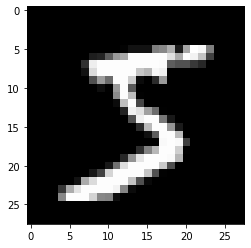

In [ ]:
image,label=dataset[0]
print('image.shape: ',image.shape)
image_permuted=image.permute(1,2,0)
plt.imshow(image[0],cmap='gray')
print('image.label:',label)

In [ ]:
val_size=10000
train_size=len(dataset)-val_size
train_ds,val_ds=random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)


(50000, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_loader=DataLoader(val_ds,batch_size*2,shuffle=True,num_workers=4,pin_memory=True)


In [ ]:
# just demo of making data into grid
for images,_ in train_loader:
  print('images.shape',images.shape)
  print('grid.shape',make_grid(images,nrow=16).shape)
  break


images.shape torch.Size([128, 1, 28, 28])
grid.shape torch.Size([3, 242, 482])


images.shape :  torch.Size([1, 28, 28])


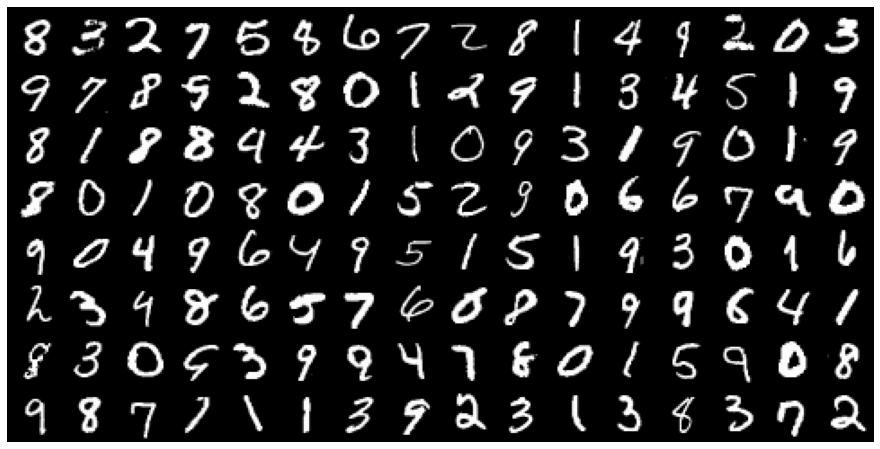

In [ ]:
for images,_ in train_loader:
  print('images.shape : ',image.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images,nrow=16).permute((1,2,0)))
  break

In [ ]:
for images, labels in train_loader:
  print('images.shape: ',images.shape)
  inputs=images.reshape(-1,784)
  print('inputs shape : ',inputs.shape)
  break

images.shape:  torch.Size([128, 1, 28, 28])
inputs shape :  torch.Size([128, 784])


In [ ]:
input_size=inputs.shape[-1]
hidden_size=32

In [ ]:
layer1=nn.Linear(input_size,hidden_size)

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs=layer1(inputs)
print('layer1_outputs.shapev :: ',layer1_outputs.shape)

layer1_outputs.shapev ::  torch.Size([128, 32])


In [ ]:
layer1_outputs_direct=inputs@layer1.weight.t()+layer1.bias
layer1_outputs_direct.shape 

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_outputs,layer1_outputs_direct)

True

In [ ]:
relu_outputs=F.relu(layer1_outputs)
print('relu output shape :',relu_outputs.shape)

print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

relu output shape : torch.Size([128, 32])
min(layer1_outputs): -0.6212301254272461
min(relu_outputs): 0.0


In [ ]:
output_size=10
layer2=nn.Linear(hidden_size,output_size)
layer2_outputs=layer2(relu_outputs)

In [ ]:
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
F.cross_entropy(layer2_outputs,labels)

tensor(2.3019, grad_fn=<NllLossBackward>)

In [ ]:
outputs=(F.relu(inputs@layer1.weight.t()+layer1.bias))@layer2.weight.t()+layer2.bias

In [ ]:
torch.allclose(outputs,layer2_outputs,1e-3)

True

In [ ]:
# we are basically writing the same thing combined.
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
combined_layer=nn.Linear(input_size,output_size)
combined_layer.weight.data=layer2.weight@layer1.weight
combined_layer.bias.data=layer1.bias@layer2.weight.t()+layer2.bias

In [ ]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [ ]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size=784
hidden_size=32
num_classes=10


In [ ]:
model=MnistModel(input_size,hidden_size=32,out_size=num_classes)


In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3291568756103516
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0139, -0.1070, -0.1425, -0.1152,  0.2822, -0.0728,  0.0200, -0.1165,
          0.1464, -0.0474],
        [ 0.0430, -0.1279, -0.1665, -0.1583,  0.2314, -0.0621,  0.0014, -0.1137,
          0.0703, -0.0553]])


In [ ]:
torch.cuda.is_available()

False

In [ ]:
jovian.commit(project='3-dnn-on-gpu')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu


'https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu'

In [ ]:
print("Hello Testing")


Hello Testing


In [ ]:

jovian.commit(project='3-dnn-on-gpu')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu


'https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu'

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break


torch.Size([128, 1, 28, 28])
cpu


In [ ]:
class DeviceDataLoader():
  def __init__(self,dl,device):
    self.dl=dl
    self.device=device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b,self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 9, 4, 9, 8, 7, 0, 6, 3, 2, 5, 1, 6, 9, 3, 9, 8, 1, 3, 2, 1, 6, 7, 7,
        1, 4, 5, 2, 6, 2, 5, 0, 7, 7, 9, 4, 1, 1, 3, 3, 6, 4, 5, 8, 0, 1, 3, 6,
        8, 0, 1, 7, 0, 2, 3, 9, 2, 9, 8, 2, 6, 9, 3, 1, 6, 7, 4, 1, 6, 5, 6, 5,
        2, 7, 0, 3, 9, 6, 6, 9, 9, 9, 5, 3, 8, 9, 5, 8, 9, 5, 2, 6, 3, 7, 3, 3,
        8, 2, 3, 9, 3, 2, 8, 3, 8, 5, 4, 2, 0, 0, 1, 7, 1, 2, 6, 6, 3, 1, 6, 7,
        7, 6, 5, 9, 1, 7, 3, 5, 0, 2, 6, 3, 7, 5, 4, 8, 2, 5, 8, 9, 5, 5, 2, 9,
        6, 9, 9, 3, 3, 5, 7, 7, 2, 9, 0, 0, 5, 6, 9, 0, 6, 2, 6, 9, 6, 8, 5, 2,
        6, 7, 8, 6, 7, 1, 9, 1, 6, 2, 0, 7, 7, 4, 3, 2, 8, 3, 8, 1, 1, 8, 8, 1,
        3, 4, 5, 6, 7, 4, 9, 2, 3, 3, 4, 6, 2, 1, 5, 1, 9, 8, 2, 8, 9, 4, 1, 3,
        1, 4, 1, 6, 5, 4, 2, 9, 3, 8, 0, 4, 2, 3, 3, 1, 5, 9, 4, 9, 3, 5, 4, 5,
        6, 9, 2, 6, 7, 9, 5, 7, 8, 7, 9, 2, 0, 1, 3, 0])


In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history


In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.09462890774011612, 'val_loss': 2.302680492401123}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.3388, val_acc: 0.8876
Epoch [1], val_loss: 0.2112, val_acc: 0.9333
Epoch [2], val_loss: 0.1532, val_acc: 0.9542
Epoch [3], val_loss: 0.1590, val_acc: 0.9531
Epoch [4], val_loss: 0.1355, val_acc: 0.9590


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1184, val_acc: 0.9643
Epoch [1], val_loss: 0.1090, val_acc: 0.9666
Epoch [2], val_loss: 0.1108, val_acc: 0.9659
Epoch [3], val_loss: 0.1147, val_acc: 0.9640
Epoch [4], val_loss: 0.1159, val_acc: 0.9611


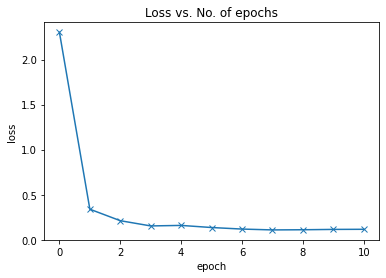

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

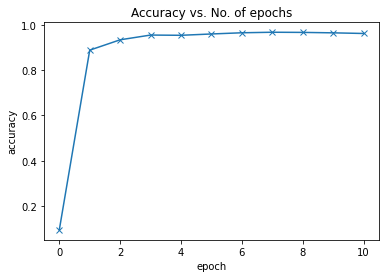

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
jovian.commit(project='3-dnn-on-gpu')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu


'https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu'

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 6 , Predicted: 6


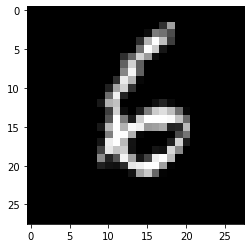

In [ ]:
img, label = test_dataset[2000]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 8 , Predicted: 8


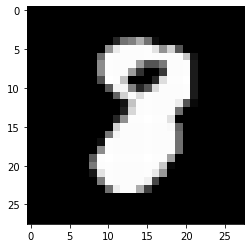

In [ ]:
img, label = test_dataset[4839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.970019519329071, 'val_loss': 0.10120471566915512}

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_loss'])

[jovian] Metrics logged.


In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')

In [ ]:
jovian.commit(project='3-dnn-on-gpu', 
              environment=None, 
              outputs=['mnist-feedforward.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu


'https://jovian.ai/sunnysingh-hj07/3-dnn-on-gpu'